In [4]:
library(GenomicFeatures)  # for the exonicParts() function
library(txdbmaker)        # for the makeTxDbFromGFF() function
library(pasillaBamSubset)
library(Rsamtools)
library(GenomicAlignments)
library(DEXSeq)
library(rtracklayer)


Attaching package: ‘txdbmaker’


The following objects are masked from ‘package:GenomicFeatures’:

    browseUCSCtrack, getChromInfoFromBiomart, makeFDbPackageFromUCSC,
    makeFeatureDbFromUCSC, makePackageName, makeTxDb,
    makeTxDbFromBiomart, makeTxDbFromEnsembl, makeTxDbFromGFF,
    makeTxDbFromGRanges, makeTxDbFromUCSC, makeTxDbPackage,
    makeTxDbPackageFromBiomart, makeTxDbPackageFromUCSC,
    supportedMiRBaseBuildValues, supportedUCSCFeatureDbTables,
    supportedUCSCFeatureDbTracks, supportedUCSCtables,
    UCSCFeatureDbTableSchema




ERROR: Error in library(pasillaBamSubset): there is no package called ‘pasillaBamSubset’


In [ ]:
python ~/R/x86_64-pc-linux-gnu-library/4.3/DEXSeq/python_scripts/dexseq_prepare_annotation.py \
Mus_musculus.GRCm39.112.gtf \
./splicing_DEXSeq/Mus_musculus.GRCm39.112_dexseq_prep.gff \
-r no


python ~/R/x86_64-pc-linux-gnu-library/4.3/DEXSeq/python_scripts/dexseq_count.py \
./splicing_DEXSeq/Mus_musculus.GRCm39.112_dexseq_prep.gff \
./after_nf-core/star_salmon/NS7_S16.markdup.sorted.bam  \
./splicing_DEXSeq/counts/NS7_S16.txt \
-f bam \
-s no \
-a 10

sed 's/\"//g' ./splicing_DEXSeq/counts/ND1_S7.txt > ./splicing_DEXSeq/counts/ND1_S7_clean.txt

or
for file in ./splicing_DEXSeq/counts/*.txt; do
    sed 's/\"//g' "$file" > "${file%.txt}_clean.txt"
done

In [5]:
txdb = makeTxDbFromGFF("../Mus_musculus.GRCm39.112.gtf")

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”
OK



In [5]:
#flattenedAnnotation = exonicParts(txdb, linked.to.single.gene.only=TRUE )
#names(flattenedAnnotation) =
#    sprintf("%s:E%0.3d", flattenedAnnotation$gene_id, flattenedAnnotation$exonic_part)

In [6]:
ND <- list.files(path = '../after_nf-core/star_salmon', pattern = "^ND.*\\.bam$", full.names = TRUE)
NS <- list.files(path = '../after_nf-core/star_salmon', pattern = "^NS.*\\.bam$", full.names = TRUE)
bamFiles = BamFileList(c(ND, NS))

library(rtracklayer)
gff <- import("../splicing_MAJIQ/Mus_musculus.GRCm39.112.gtf_to_gff.gff")
## adjust seqnames to match Bam files
seqlevels(gff) <- paste("chr", seqlevels(gff), sep="")
genes <- split(gff, mcols(gff)$gene_id)

# Define metadata for 10 samples
sample_metadata <- data.frame(
  SampleID = paste0("Sample", 1:10),
  Condition = c(rep('DMSO', 5), rep("Senexin", 5)),
  row.names = paste0("Sample", 1:10)
)

# Convert the data frame to DataFrame if needed for SummarizedExperiment
sample_metadata <- DataFrame(sample_metadata)

ERROR: Error in BamFileList(c(ND, NS)): could not find function "BamFileList"


In [5]:
library(parallel)
num_cores <- 2
         
process_bam <- function(bamFile) {
  # Summarize overlaps for this BAM file
  summarizeOverlaps(genes, bamFile, mode = "IntersectionNotEmpty")
}

# Apply the function in parallel to each BAM file
genehits_list <- mclapply(bamFiles, process_bam, mc.cores = num_cores)

# Combine the results (if needed) after processing all BAM files
# For example, summing across all BAM files if you want to aggregate the counts
# Convert the list of results into a SummarizedExperiment object
#combined_genehits <- do.call(cbind, genehits_list)

In [1]:
design <- data.frame(
condition=c(rep('DMSO', 5), rep("Senexin", 5)),
replicate=c(rep(1, 5), rep(2, 5)),
type=rep("paired-read", 10),
countfiles=colnames(df[2:11]), stringsAsFactors=TRUE)

ERROR: Error in df[2:11]: object of type 'closure' is not subsettable


In [123]:
seqlevels(gff) <- gsub("^chr", "", seqlevels(gff))
# Check BAM sequence names
bamHeader <- scanBamHeader(bamFiles[[1]])
bamSeqnames <- names(bamHeader[[1]]$targets)

# Check GFF sequence names
gffSeqnames <- seqlevels(gff)

print(bamSeqnames)
print(gffSeqnames)

ERROR: Error in bamHeader[[1]]$targets: $ operator is invalid for atomic vectors


In [ ]:
dxd = DEXSeqDataSetFromSE(genehits, design= ~ sample + exon + condition:exon )

In [ ]:
#другой вариант, после обработки питоновским файлом

In [2]:
gff <- import("Mus_musculus.GRCm39.112_dexseq_prep.gff")
## adjust seqnames to match Bam files
seqlevels(gff) <- paste("chr", seqlevels(gff), sep="")
genes <- split(gff, mcols(gff)$gene_id)

In [10]:
folder_path <- "./counts/"

# Get a list of all .txt files in the folder
file_list <- list.files(path = folder_path, pattern = "*_clean.txt", full.names = TRUE)

# Read each file into a dataframe and store them in a list
dataframes_list <- lapply(file_list, function(file) {
  read.table(file, header = FALSE, sep = "\t") 
})

# Optionally, set names for each dataframe in the list
names(dataframes_list) <- basename(file_list)

In [11]:
for (i in 1:10) {
    dataframes_list[[i]] <- as.data.frame(dataframes_list[[i]])
    colnames(dataframes_list[[i]]) <- c('gene', basename(file_list)[[i]])
}

In [12]:
df <- dataframes_list[[1]]
for (i in 2:10) {
  df <- merge(df, dataframes_list[[i]], by='gene')
}

In [ ]:
design <- data.frame(
condition=c(rep('DMSO', 5), rep("Senexin", 5)),
replicate=factor(c(1, 2, 3, 4, 5, 1, 2, 3, 4, 5)),
type=rep("paired-read", 10), stringsAsFactors=TRUE)
#sample=colnames(df[2:11]), stringsAsFactors=TRUE)
#на биостарс увидела, что ошибка может быть из-за дополнительной колонки с сэмплами (DEXSeq сам создает)

count_matrix <- as.matrix(df[, 2:11])
non_zero_rows <- rowSums(count_matrix) > 0
count_matrix <- count_matrix[non_zero_rows, ]

gene_id <- df[, 1]  # gene annotations
# Create a data frame for rowData with gene_id
row_data <- DataFrame(gene_id = df[1][non_zero_rows, ], tx_name = df[1][non_zero_rows, ])

# Create a SummarizedExperiment object
se <- SummarizedExperiment(
    assays = list(counts = count_matrix),
    colData = design,
    rowData = row_data
)

dxd = DEXSeqDataSetFromSE(se, design= ~ sample + exon + condition:exon )

In [99]:
split( seq_len(ncol(dxd)), colData(dxd)$exon )
sampleAnnotation( dxd )

$others
 [1] 11 12 13 14 15 16 17 18 19 20

$this
 [1]  1  2  3  4  5  6  7  8  9 10

DataFrame with 10 rows and 4 columns
              sample condition replicate        type
            <factor>  <factor>  <factor>    <factor>
1  ND1_S7_clean.txt    DMSO            1 paired-read
2  ND3_S11_clean.txt   DMSO            2 paired-read
3  ND4_S9_clean.txt    DMSO            3 paired-read
4  ND6_S13_clean.txt   DMSO            4 paired-read
5  ND7_S15_clean.txt   DMSO            5 paired-read
6  NS1_S8_clean.txt    Senexin         1 paired-read
7  NS3_S12_clean.txt   Senexin         2 paired-read
8  NS4_S10_clean.txt   Senexin         3 paired-read
9  NS6_S14_clean.txt   Senexin         4 paired-read
10 NS7_S16_clean.txt   Senexin         5 paired-read

In [100]:
dxd = estimateSizeFactors( dxd )

In [101]:
dxd = estimateDispersions( dxd )

ERROR: Error in `$<-.data.frame`(`*tmp*`, "dispersion", value = NA): replacement has 1 row, data has 0


In [ ]:
plotDispEsts( dxd )

In [ ]:
dxd = testForDEU( dxd )

In [ ]:
dxd = estimateExonFoldChanges( dxd, fitExpToVar="condition")

In [ ]:
dxr1 = DEXSeqResults( dxd )
dxr1

In [ ]:
mcols(dxr1)$description
##  [1] "group/gene identifier"                                       
##  [2] "feature/exon identifier"                                     
##  [3] "mean of the counts across samples in each feature/exon"      
##  [4] "exon dispersion estimate"                                    
##  [5] "LRT statistic: full vs reduced"                              
##  [6] "LRT p-value: full vs reduced"                                
##  [7] "BH adjusted p-values"                                        
##  [8] "exon usage coefficient"                                      
##  [9] "exon usage coefficient"                                      
## [10] "relative exon usage fold change"                             
## [11] "GRanges object of the coordinates of the exon/feature"       
## [12] "matrix of integer counts, of each column containing a sample"
## [13] "list of transcripts overlapping with the exon"
#From this object, we can ask how many exonic regions are significant with a false discovery rate of 10%:

table ( dxr1$padj < 0.1 )
## For example:
## FALSE  TRUE 
##   426    17
#We may also ask how many genes are affected

table ( tapply( dxr1$padj < 0.1, dxr1$groupID, any ) )

In [ ]:
#

In [ ]:
#Конечный вариант

In [1]:
library(DEXSeq)
library(rtracklayer)

Loading required package: BiocParallel

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading requ

In [2]:
getwd()

[1] "/tank/projects/shipulina_cdk/splicing_DEXSeq"

In [3]:
countFiles = list.files('./counts', pattern="_clean.txt$", full.names=TRUE)
basename(countFiles)

[1] "ND1_S7_clean.txt"  "ND3_S11_clean.txt" "ND4_S9_clean.txt" 
 [4] "ND6_S13_clean.txt" "ND7_S15_clean.txt" "NS1_S8_clean.txt" 
 [7] "NS3_S12_clean.txt" "NS4_S10_clean.txt" "NS6_S14_clean.txt"
[10] "NS7_S16_clean.txt"

In [6]:
#gff <- import("Mus_musculus.GRCm39.112_dexseq_prep.gff")
flattenedFile = list.files('./', pattern="gff$", full.names=TRUE)
basename(flattenedFile)
## adjust seqnames to match Bam files
#seqlevels(gff) <- paste("chr", seqlevels(gff), sep="")
#genes <- split(gff, mcols(gff)$gene_id)

[1] "Mus_musculus.GRCm39.112_dexseq_prep.gff"

In [8]:
sampleTable <- data.frame(
condition=c(rep('DMSO', 5), rep("Senexin", 5)), stringsAsFactors=TRUE,
mouse=factor(c(1, 2, 3, 4, 5, 1, 2, 3, 4, 5)))

In [9]:
dxd = DEXSeqDataSetFromHTSeq(
   countFiles,
   sampleData=sampleTable,
   design= ~ sample + exon + condition:d3exon,
   flattenedfile=flattenedFile)

converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
“some variables in design formula are characters, converting to factors”


In [10]:
head( counts(dxd), 5 )
head( featureCounts(dxd), 5 )

ENSMUSG00000000001:E001,2424,2418,3993,2434,2453,2343,3554,3993,2629,2833,1961,2325,3880,3113,2831,1528,3299,3718,3171,3303
ENSMUSG00000000001:E002,247,392,564,377,368,274,478,526,405,513,4138,4351,7309,5170,4916,3597,6375,7185,5395,5623
ENSMUSG00000000001:E003,236,283,354,326,329,183,384,365,367,353,4149,4460,7519,5221,4955,3688,6469,7346,5433,5783
ENSMUSG00000000001:E004,216,239,428,310,306,159,405,389,315,297,4169,4504,7445,5237,4978,3712,6448,7322,5485,5839
ENSMUSG00000000001:E005,274,287,525,386,375,178,439,469,398,435,4111,4456,7348,5161,4909,3693,6414,7242,5402,5701


,1,2,3,4,5,6,7,8,9,10
ENSMUSG00000000001:E001,2424,2418,3993,2434,2453,2343,3554,3993,2629,2833
ENSMUSG00000000001:E002,247,392,564,377,368,274,478,526,405,513
ENSMUSG00000000001:E003,236,283,354,326,329,183,384,365,367,353
ENSMUSG00000000001:E004,216,239,428,310,306,159,405,389,315,297
ENSMUSG00000000001:E005,274,287,525,386,375,178,439,469,398,435


In [11]:
dxd = estimateSizeFactors( dxd )

In [12]:
dxd = estimateDispersions( dxd )

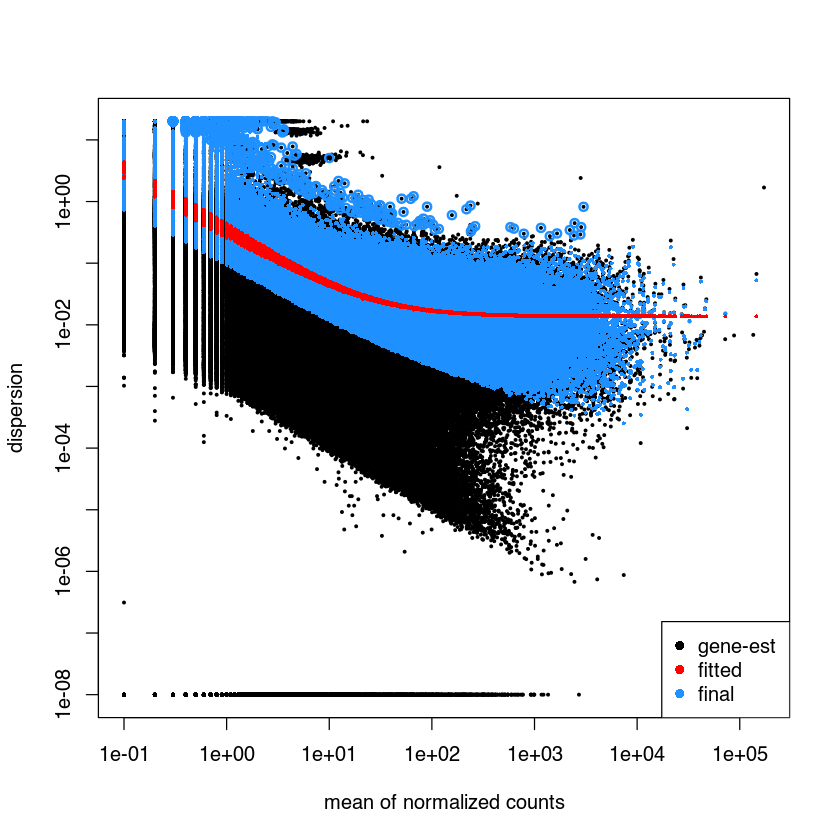

In [9]:
plotDispEsts( dxd )

In [10]:
dxd = testForDEU( dxd )

#The function testForDEU() performs these tests for each exon in each gene.

In [11]:
dxr1 = DEXSeqResults( dxd )
dxr1


LRT p-value: full vs reduced

DataFrame with 470418 rows and 10 columns
                                   groupID   featureID exonBaseMean dispersion
                               <character> <character>    <numeric>  <numeric>
ENSMUSG00000000001:E001 ENSMUSG00000000001        E001     2806.982 0.02098070
ENSMUSG00000000001:E002 ENSMUSG00000000001        E002      395.570 0.00662453
ENSMUSG00000000001:E003 ENSMUSG00000000001        E003      307.413 0.00845783
ENSMUSG00000000001:E004 ENSMUSG00000000001        E004      292.278 0.00508871
ENSMUSG00000000001:E005 ENSMUSG00000000001        E005      359.406 0.00762983
...                                    ...         ...          ...        ...
ENSMUSG00002076987:E001 ENSMUSG00002076987        E001            0         NA
ENSMUSG00002076988:E001 ENSMUSG00002076988        E001            0         NA
ENSMUSG00002076989:E001 ENSMUSG00002076989        E001            0         NA
ENSMUSG00002076991:E001 ENSMUSG00002076991        E001    

In [12]:
table ( dxr1$padj < 0.1 )


 FALSE   TRUE 
266923     64 

In [13]:
formulaFullModel    =  ~ sample + exon + mouse:exon + condition:exon
formulaReducedModel =  ~ sample + exon + mouse:exon 
dxd = estimateDispersions( dxd, formula = formulaFullModel )

you had estimated dispersions, replacing these



In [14]:
dxd = testForDEU( dxd, 
    reducedModel = formulaReducedModel, 
        fullModel = formulaFullModel )

2 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT



In [15]:
dxr2 = DEXSeqResults( dxd )

In [16]:
table( dxr2$padj < 0.1 )


 FALSE   TRUE 
125540   1499 

In [17]:
table( before = dxr1$padj < 0.1, now = dxr2$padj < 0.1 )

       now
before   FALSE   TRUE
  FALSE 125540   1461
  TRUE       0     38

In [18]:
#for the first formula, amount of affected genes
table ( tapply( dxr1$padj < 0.1, dxr1$groupID, any ) )

#for the second one
table ( tapply( dxr2$padj < 0.1, dxr2$groupID, any ) )


FALSE  TRUE 
 3628    56 


FALSE  TRUE 
  496  1107 

In [33]:
dxr2_no_na <- dxr2[!is.na(dxr2$padj), ]

In [39]:
library(biomaRt)

In [40]:
# Connect to the Ensembl database for mouse
ensembl <- useMart("ensembl")
mouse <- useDataset("mmusculus_gene_ensembl", mart = ensembl)

#отфильтровали по padj < 0.1
gene_info <- getBM(attributes = c("ensembl_gene_id", "external_gene_name"), 
                   filters = "ensembl_gene_id", 
                   values = unique(dxr2_no_na[dxr2_no_na$padj < 0.1, ]$groupID), 
                   mart = mouse)

print(gene_info)

        ensembl_gene_id external_gene_name
1    ENSMUSG00000000056               Narf
2    ENSMUSG00000000078               Klf6
3    ENSMUSG00000000149              Gna12
4    ENSMUSG00000000184              Ccnd2
5    ENSMUSG00000000355              Mcts1
6    ENSMUSG00000000374           Trappc10
7    ENSMUSG00000000384              Tbrg4
8    ENSMUSG00000000568             Hnrnpd
9    ENSMUSG00000000600              Krit1
10   ENSMUSG00000000743             Chmp1a
11   ENSMUSG00000000787              Ddx3x
12   ENSMUSG00000000826             Dnajc5
13   ENSMUSG00000000861             Bcl11a
14   ENSMUSG00000000881               Dlg3
15   ENSMUSG00000001016               Ilf2
16   ENSMUSG00000001127               Araf
17   ENSMUSG00000001138              Cnnm3
18   ENSMUSG00000001227             Sema6b
19   ENSMUSG00000001270                Ckb
20   ENSMUSG00000001415               Smg5
21   ENSMUSG00000001467              Cyp51
22   ENSMUSG00000001707             Eef1e1
23   ENSMUS

In [60]:
toString(gene_info$external_gene_name)

[1] "Narf, Klf6, Gna12, Ccnd2, Mcts1, Trappc10, Tbrg4, Hnrnpd, Krit1, Chmp1a, Ddx3x, Dnajc5, Bcl11a, Dlg3, Ilf2, Araf, Cnnm3, Sema6b, Ckb, Smg5, Cyp51, Eef1e1, Nfix, Grik3, Pdzd4, Idh3g, Unc119, Dhrs1, Tmem161a, Tsc2, Golga2, Plekha3, Atg4d, Hdgfl2, Mcm2, Ap2a2, Cdkn1b, Ap1m1, Rab8a, Fam32a, Abcf3, Car11, Glg1, Csnk1g2, Etv3, Rps11, Calb2, Snrnp200, Calr, Ssbp2, Dnmt1, 9330159F19Rik, Ddx56, Tmed4, Ndrg2, Stxbp2, Chn2, Chmp2b, Pias4, Sgta, Hnrnpa2b1, Txn2, Msh6, Pafah1b3, Dnajb1, Trim28, Mef2c, Eif4g2, Kit, Ncoa2, Smpd4, Kctd20, Tpr, Atp6v1b2, Kmt2b, Tfpt, Srm, Ptbp1, Rundc3a, Gtf2h1, Aplp1, P4htm, Usp19, Cdc42, Cdk4, Psmd2, Atp1a2, Mark3, Ppp2r1a, Tinf2, Homer1, Zmiz1, Hnrnph1, Tle1, Herpud2, Ubqln4, Rbfox1, Vdac3, Nf2, Ap1b1, Vav2, Ubp1, Nxf1, Fads1, Pabpc4, Git1, Rpl15, Ptprs, Atraid, Atad1, Pea15a, Dynlt2b, Anapc1, Ankrd28, Strip1, Kif1a, Tex261, Hnrnpl, Hmgb3, Map2, Ttbk1, Hspa8, Arnt2, Surf1, Lcorl, Adss2, Kcnq2, Lnx2, Lamp2, Pacsin2, Tox4, Aldoc, Zfp207, Timp2, Abr, Elmo2, Serinc3, Crk, Nkiras2, Cyb5r3, Stard3, Ksr1, Smurf2, Srsf1, Mapt, Myo1b, Rpain, Chd3, Ncor1, Trim37, Dync1h1, Zfyve27, Mrpl58, Arrb1, Rab3d, Slc25a22, Scrn1, Atp6v1e1, Rps6kl1, Arhgef25, Xab2, Cops6, Lyst, Lrp11, Serinc1, Lims1, Sgk1, Socs2, Hsp90b1, Hnrnph3, Macroh2a2, Slc29a3, Vps54, Apc2, Slc1a4, Rab1a, Gamt, Tcf3, Rab36, Nav3, Cabin1, Sf3a2, Xpo1, Nsg2, Mdh1, Gfpt2, Vdac1, Gabrg2, Rps27a, Ppp4r3b, Cnot8, Ppm1d, Bzw2, Pdia6, Tspan13, Sdc1, Trib2, Map3k3, Gga3, Cluh, Acox1, Ywhae, Prpf8, Luc7l3, Ubtf, Adam11, Nmt1, Klhl28, Sel1l, Trim9, Papola, Srsf5, Mta1, Numb, Ylpm1, Wars1, Meg3, Hsp90aa1, Klc1, Kif26a, Ggps1, Carmil1, Exoc2, Hivep1, Nup153, Sema4d, Txndc15, Caml, Adcy2, Ccdc127, Mccc2, Hmgcr, Plk2, Il6st, Dlg5, Ppp3cb, Zswim8, Arf4, Bap1, Nisch, Spcs1, Tkt, Extl3, Akap11, Trim35, Slc39a14, Bmp1, Gpc5, Drosha, Carmil3, Nadk2, Trio, Ank, Khdrbs3, Emc2, Sqle, Asap1, Wnt7b, Zc3h7b, Cacna1i, Csnk1e, C1qtnf6, Twf1, Nell2, Septin3, Srebf2, Pde1b, Shisa9, Fgf12, Tmem44, Cyc1, Plec, Scrib, Hira, Cpox, Thap7, Lztr1, Igsf11, Tnk2, Gsk3b, Abcc5, Rabl3, Iqcb1, Slc49a4, Robo1, Eif4a2, Masp1, App, Itsn1, Adcy6, Map3k12, Sympk, Gps2, Agap3, Pcbp4, Tiam2, Pde10a, Phf10, Tnfrsf21, Satb1, Hsp90ab1, Enpp5, Cnpy3, Foxp4, Brd4, Ppil1, Epb41l3, Prkd3, Vapa, Nrxn1, Cacna1h, Srbd1, Mapk8ip3, Jpt2, Ift140, Dusp1, Snrpc, Sap130, Brd2, Etf1, Ercc3, Csnk2b, Bag6, Atp6v1g2, Ndfip1, Gabbr1, Lars1, Ppp2r2b, Dpysl3, Jakmip2, Sncaip, Me2, Csnk1a1, Fech, Dctn4, Gnaq, Cyb5a, Fads2, Ddb1, Zfand5, Rtn3, Jak2, Chka, Aip, Sf3b2, Grk2, Cpt1a, Smarca2, Kat5, Smc5, Men1, Gpr137, Vegfb, Stip1, Xpnpep1, Fundc1, Gps1, Scd2, Sfxn3, Tbl1x, Hsd17b10, Huwe1, Rps24, Itgb8, Cdk2, Hdhd2, Paox, Dpysl4, Ptdss2, Zfp711, Tnrc6c, Podxl, Uqcrc1, Rab40c, Atp5f1c, Hgs, Faf2, Unc5a, Cops5, Stau2, Nrp2, Carf, Trak2, Khdrbs2, Map4k4, Inpp4a, Imp4, Dst, Dnpep, Psmd1, Epha4, Cops7b, Mrpl44, Rnpepl1, Lrrfip1, Relch, Actr3, Dbi, Xpr1, Stx6, Angel2, Frmd4a, Ppp6c, Kif5c, Odf2, Lrsam1, Niban2, Dpm2, Ralgds, Dnm1, Nr4a2, Olfm1, Fubp3, Hspa5, Rab14, Pmpca, Zmynd19, Marchf7, Ube2e3, Atf2, Lin7c, Hipk3, Trim44, Meis2, Mapk8ip1, Adal, Snap25, Snap23, Vps39, Dnaaf9, Rassf2, Slc23a2, Trpm7, Polr1b, Stmn2, Rtf2, Gnas, Dok5, Acss2, Epb41l1, Src, Tnik, Dclk1, Nbea, Tsc22d2, Slc27a3, Tpm3, Vcam1, Fubp1, Efna3, Rit1, Lamtor2, Dclk2, Fbxw7, Acp6, Pias3, Mettl14, Snx27, Mrpl9, Ppp3ca, Bcl10, Rps20, Sdcbp, Lmo4, Ugcg, Aco1, Slc44a1, Nfx1, Ubap2, Vcp, Rps6, Scp2, Lrp8, Tmem59, Dyrk2, Ephb2, Rnf220, Ebna1bp2, Capzb, Ptp4a2, Nipal3, Srrm1, Maco1, Ncdn, Nudc, Meaf6, Fam76a, Inpp5b, Acot7, Tmub1, Ube4b, Errfi1, Pex14, Mtor, Tprg1l, Acap3, Add1, Crmp1, Dpysl5, Tbc1d14, Uchl1, Epha5, Paics, Mtf2, Klhl8, Hnrnpdl, Ran, Cct6a, Anapc5, Dhx37, Ddx51, Gpc2, St7, Mad1l1, Fscn1, Cdk8, Auts2, Bcl7b, Cul1, Cux1, Gnb2, Gigyf1, Mcm7, Exoc4, Calu, Ccdc136, Adcyap1r1, Gsdme, Dbpht2, Cct7, Zfp638, Foxp1, Ruvbl1, Nup210, Tmem43, Arl8b, Plxnd1, Adipor2, Ddx47, Lmo3, Plekha5, Slco1c1, Golt1b, Slc6a1, Necap1, Mark4, Cyfip1, Kctd15, Slc17a6, Apba2, Chrna7,

In [64]:
class(dxr1)

[1] "DEXSeqResults"
attr(,"package")
[1] "DEXSeq"

In [67]:
is_list_column <- sapply(dxr1, is.list)
is_list_column

groupID    featureID exonBaseMean   dispersion         stat       pvalue 
       FALSE        FALSE        FALSE        FALSE        FALSE        FALSE 
        padj  genomicData    countData  transcripts 
       FALSE        FALSE        FALSE         TRUE

In [68]:
dxr1[is_list_column] <- lapply(dxr1[is_list_column], function(col) sapply(col, toString))

In [69]:
write.csv(dxr1,"dxr1.csv", row.names = FALSE)

In [70]:
is_list_column <- sapply(dxr2, is.list)
is_list_column
dxr2[is_list_column] <- lapply(dxr2[is_list_column], function(col) sapply(col, toString))

groupID    featureID exonBaseMean   dispersion         stat       pvalue 
       FALSE        FALSE        FALSE        FALSE        FALSE        FALSE 
        padj  genomicData    countData  transcripts 
       FALSE        FALSE        FALSE         TRUE

In [71]:
write.csv(dxr2,"dxr2.csv", row.names = FALSE)

In [50]:
library(KEGGREST)

In [59]:
toString(unique(gene_info$ensembl_gene_id))

[1] "ENSMUSG00000000056, ENSMUSG00000000078, ENSMUSG00000000149, ENSMUSG00000000184, ENSMUSG00000000355, ENSMUSG00000000374, ENSMUSG00000000384, ENSMUSG00000000568, ENSMUSG00000000600, ENSMUSG00000000743, ENSMUSG00000000787, ENSMUSG00000000826, ENSMUSG00000000861, ENSMUSG00000000881, ENSMUSG00000001016, ENSMUSG00000001127, ENSMUSG00000001138, ENSMUSG00000001227, ENSMUSG00000001270, ENSMUSG00000001415, ENSMUSG00000001467, ENSMUSG00000001707, ENSMUSG00000001911, ENSMUSG00000001985, ENSMUSG00000002006, ENSMUSG00000002010, ENSMUSG00000002058, ENSMUSG00000002332, ENSMUSG00000002342, ENSMUSG00000002496, ENSMUSG00000002546, ENSMUSG00000002733, ENSMUSG00000002820, ENSMUSG00000002833, ENSMUSG00000002870, ENSMUSG00000002957, ENSMUSG00000003031, ENSMUSG00000003033, ENSMUSG00000003037, ENSMUSG00000003039, ENSMUSG00000003234, ENSMUSG00000003273, ENSMUSG00000003316, ENSMUSG00000003345, ENSMUSG00000003382, ENSMUSG00000003429, ENSMUSG00000003657, ENSMUSG00000003660, ENSMUSG00000003814, ENSMUSG00000003992, ENSMUSG00000004099, ENSMUSG00000004360, ENSMUSG00000004393, ENSMUSG00000004394, ENSMUSG00000004558, ENSMUSG00000004626, ENSMUSG00000004633, ENSMUSG00000004843, ENSMUSG00000004934, ENSMUSG00000004937, ENSMUSG00000004980, ENSMUSG00000005354, ENSMUSG00000005370, ENSMUSG00000005447, ENSMUSG00000005483, ENSMUSG00000005566, ENSMUSG00000005583, ENSMUSG00000005610, ENSMUSG00000005672, ENSMUSG00000005886, ENSMUSG00000005899, ENSMUSG00000005936, ENSMUSG00000006005, ENSMUSG00000006273, ENSMUSG00000006307, ENSMUSG00000006335, ENSMUSG00000006442, ENSMUSG00000006498, ENSMUSG00000006575, ENSMUSG00000006599, ENSMUSG00000006651, ENSMUSG00000006675, ENSMUSG00000006676, ENSMUSG00000006699, ENSMUSG00000006728, ENSMUSG00000006998, ENSMUSG00000007097, ENSMUSG00000007411, ENSMUSG00000007564, ENSMUSG00000007589, ENSMUSG00000007617, ENSMUSG00000007817, ENSMUSG00000007850, ENSMUSG00000008305, ENSMUSG00000008429, ENSMUSG00000008604, ENSMUSG00000008658, ENSMUSG00000008892, ENSMUSG00000009073, ENSMUSG00000009090, ENSMUSG00000009621, ENSMUSG00000009741, ENSMUSG00000010097, ENSMUSG00000010663, ENSMUSG00000011257, ENSMUSG00000011877, ENSMUSG00000012405, ENSMUSG00000013236, ENSMUSG00000013622, ENSMUSG00000013662, ENSMUSG00000013698, ENSMUSG00000014075, ENSMUSG00000014355, ENSMUSG00000014496, ENSMUSG00000014601, ENSMUSG00000014602, ENSMUSG00000014748, ENSMUSG00000015165, ENSMUSG00000015217, ENSMUSG00000015222, ENSMUSG00000015599, ENSMUSG00000015656, ENSMUSG00000015709, ENSMUSG00000015790, ENSMUSG00000015882, ENSMUSG00000015961, ENSMUSG00000016346, ENSMUSG00000016520, ENSMUSG00000016534, ENSMUSG00000016664, ENSMUSG00000016831, ENSMUSG00000017390, ENSMUSG00000017421, ENSMUSG00000017466, ENSMUSG00000017631, ENSMUSG00000017670, ENSMUSG00000017707, ENSMUSG00000017776, ENSMUSG00000017837, ENSMUSG00000018042, ENSMUSG00000018167, ENSMUSG00000018334, ENSMUSG00000018363, ENSMUSG00000018379, ENSMUSG00000018411, ENSMUSG00000018417, ENSMUSG00000018449, ENSMUSG00000018474, ENSMUSG00000018501, ENSMUSG00000018548, ENSMUSG00000018707, ENSMUSG00000018820, ENSMUSG00000018858, ENSMUSG00000018909, ENSMUSG00000019066, ENSMUSG00000019082, ENSMUSG00000019124, ENSMUSG00000019210, ENSMUSG00000019235, ENSMUSG00000019467, ENSMUSG00000019470, ENSMUSG00000019494, ENSMUSG00000019726, ENSMUSG00000019796, ENSMUSG00000019877, ENSMUSG00000019920, ENSMUSG00000019970, ENSMUSG00000020027, ENSMUSG00000020048, ENSMUSG00000020069, ENSMUSG00000020086, ENSMUSG00000020100, ENSMUSG00000020128, ENSMUSG00000020135, ENSMUSG00000020142, ENSMUSG00000020149, ENSMUSG00000020150, ENSMUSG00000020167, ENSMUSG00000020175, ENSMUSG00000020181, ENSMUSG00000020196, ENSMUSG00000020211, ENSMUSG00000020290, ENSMUSG00000020297, ENSMUSG00000020321, ENSMUSG00000020363, ENSMUSG00000020402, ENSMUSG00000020436, ENSMUSG00000020460, ENSMUSG00000020463, ENSMUSG00000020515, ENSMUSG00000020525, ENSMUSG00000020547, ENSMUSG00000020571, ENSMUSG00000020577, ENSMUSG00000020592, ENSMUSG00000020601, ENSMUSG00000020700, ENSMUSG00000020740, ENSMUSG00000020